In [1]:
# imports (this can take some time!)
using DrWatson
@quickactivate "IEEE14"

using NonLinearSystemNeuralNetworkFMU
using ChainRulesCore
using Flux
using LinearAlgebra
using Statistics
using Plots

include("utils.jl")
include("trainSupervised.jl")
include("trainUnsupervised.jl")
include("trainSemiSupervised.jl")

trainModelSemisupervised (generic function with 1 method)

# Introduction
- Comparison between Supervised training, Unsupervised training and a combination of them for learning of SimpleLoop data.
- What is SimpleLoop?: https://github.com/AnHeuermann/NonLinearSystemNeuralNetworkFMU.jl/tree/main/examples/SimpleLoop

SimpleLoop describes a growing circle and a moving line and contains a non-linear system solving for the intersection points of the two objects.
$$r^2 = x^2 + y^2$$
$$rs + b = x + y$$
Inputs to the Surrogate are $r$ and $s$ and $b$ is a parameter.
Output of the Surrogate is $y$ and $x$ can be computed from $y$: $x = rs + b - y$

**Supervised training**:
- input output pairs: $\{(x_{1},y_{1}),...,(x_{N},\;y_{N})\}$
- The loss function is MSE: $$L = \sum_i \big( f(x_i ; \theta)-y^*_i \big)^2$$

**Unsupervised Training**:
- only input, no input output pairs: $\{x_{1},...,x_{N}\}$
- The loss function is measuring the residual of output, which should be $0$ at solution: $$L = \sum_i R(f(x_i ; \theta))$$

**Semi-Supervised Training**:
- input output pairs
- The loss function is combining MSE and residual information: $$L = \sum_i \alpha_0 \big( f(x_i ; \theta)-y^*_i \big)^2 + \alpha_1 R(x_i)$$
- hyperparameters for weighting sum to $1$ with: $\alpha_0 + \alpha_1 = 1$
- in all experiments i used: $\alpha_0 = 0.8$ and $\alpha_1 = 0.2$

**Clustering**:
- applied to output data using KMeans
- idea is to identify unique solutions in data and train on these solutions separately

In [47]:
# data loading into 
fileName = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/data/eq_14.csv"
nInputs = 2
nOutputs = 1

comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu("/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/simpleLoop.interface.fmu",
                                                            "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/profilingInfo.bson",
                                                            "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/simpleLoop_1000/temp-profiling/simpleLoop.c")

(FMU:            simpleLoop
InstanceName:   simpleLoop
Address:        Ptr{Nothing} @0x000000000f249e50
State:          2
Logging:        0
FMU time:       0.0
FMU states:     nothing, Model name:        simpleLoop
Type:              0, ProfilingInfo[ProfilingInfo(EqInfo(14, 2512, 0.000317798, 1.5827e-5, 0.06756972823105675), ["y"], [11], ["s", "r"], NonLinearSystemNeuralNetworkFMU.MinMaxBoundaryValues{Float64}([0.0, 0.95], [1.4087228258248679, 3.15]))], UInt32[0x00000004], UInt32[0x00000001, 0x00000000], 14, 1)

# 1. Experiment
The output data is **first clustered** and then Supervised, Unsupervised and Semi-Supervised are trained. During training, MSE loss and Residual loss on test data is tracked. After training, trained model predictions on test data are plotted in a scatter plot.

In [3]:
# preparation of 1. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)  

# concat in and out data
in_data = hcat(train_in, test_in)
out_data = hcat(train_out, test_out)

x = compute_x_from_y.(in_data[1,:], in_data[2,:], out_data[1,:])
out_data = hcat(x, out_data')'
# cluster out data
cluster_indices, num_clusters = cluster_data(out_data)
# extract cluster
cluster_index = 1
in_data = extract_cluster(in_data, cluster_indices, cluster_index)
out_data = extract_cluster(out_data, cluster_indices, cluster_index)
out_data = out_data[2,:]
out_data = reshape(out_data, 1, length(out_data))
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data)
# min max scaling
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

339-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float64}}, shuffle=true)
  with first element:
  (2×1 Matrix{Float32}, 1×1 Matrix{Float64},)

In [48]:
# definition of the model for all experiments
# simple MLP with one hidden layer
hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)
# Adam optimizer with learning rate 1e-4
opt = Flux.Adam(1e-4)
# training is done for 100 epochs
epochs = 100

100

In [5]:
# 1. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2)

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.008129836722678979, 0.0006429960887669305, 0.0002499587244940677, 0.0002129745880926204, 0.00020203235147667748, 0.0001374553167847745, 0.00012774985713238116, 0.00017093910117068993, 0.00011318522084811469, 6.967312205741105e-5  …  6.3346478484007756e-6, 7.94179388002748e-6, 3.298800481308407e-6, 2.875918295389272e-5, 3.931404651059955e-6, 1.0751254015865909e-5, 2.5047326559372408e-5, 4.4244148875307846e-6, 1.1081530071731906e-5, 5.408201708208565e-6], 7.929354190826416)

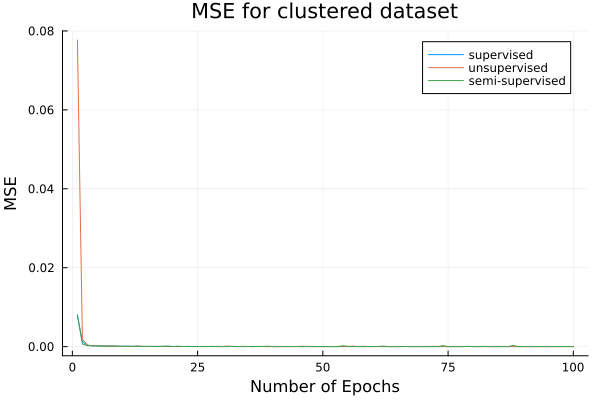

In [6]:
# results of 1. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

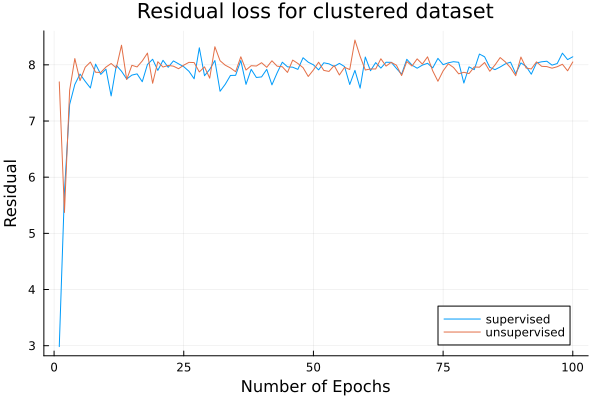

In [7]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual loss for clustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

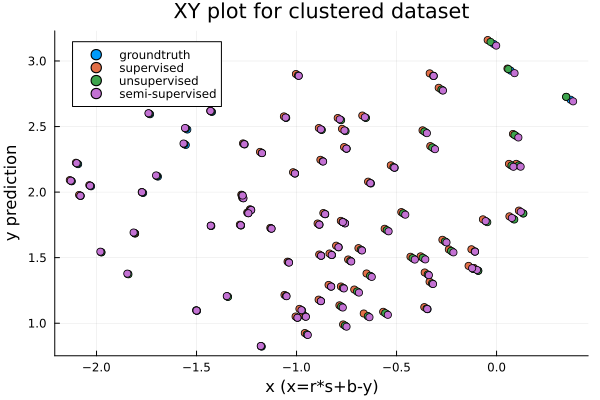

In [8]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth") # reconstruct
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for clustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 1. Experiment
- Unsupervised training **can converge** to a true solution
- Unsupervised training is also **unguided**, it depends on initialization of the parameters to which solution the Network converges, if at all.
- Unsupervised is only superior to Supervised when clustering is not available: more compute while training, unguided
- Semi-Supervised is an option, when a preferred solution and unique data exists: less data generation, guiding of Unsupervised training

# 2. Experiment
For the second experiment, the only difference to the first is that **no clustering** is done.

In [49]:
# preparation of 2. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true) #???

900-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true)
  with first element:
  (2×1 Matrix{Float32}, 1×1 Matrix{Float32},)

In [10]:
# 2. experiment
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs, h1=0.8, h2=0.2)

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.089846395f0, 0.08890974f0, 0.0902778f0, 0.089115955f0, 0.09043767f0, 0.09403998f0, 0.09361887f0, 0.09164186f0, 0.08997843f0, 0.09183442f0  …  0.092286006f0, 0.0915453f0, 0.09337364f0, 0.093206346f0, 0.09259822f0, 0.09525142f0, 0.09205914f0, 0.09427247f0, 0.09321459f0, 0.09193233f0], 20.54603886604309)

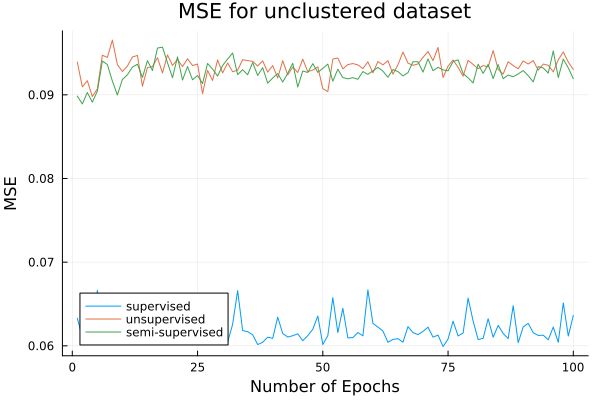

In [11]:
# results of 2. experiment
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
title!("MSE for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("MSE")

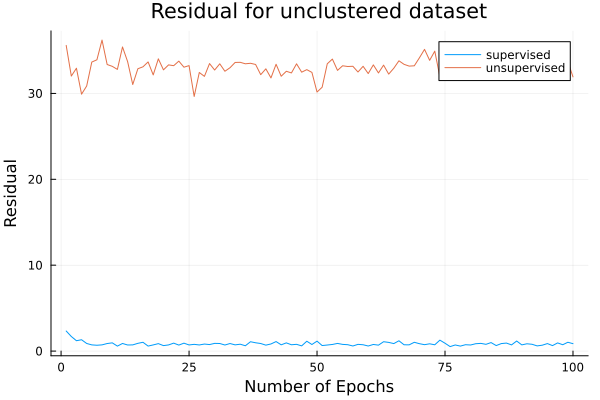

In [12]:
plot_loss_history(res_sup; label="supervised")
plot_loss_history!(res_unsup; label="unsupervised")
title!("Residual for unclustered dataset")
xlabel!("Number of Epochs")
ylabel!("Residual")

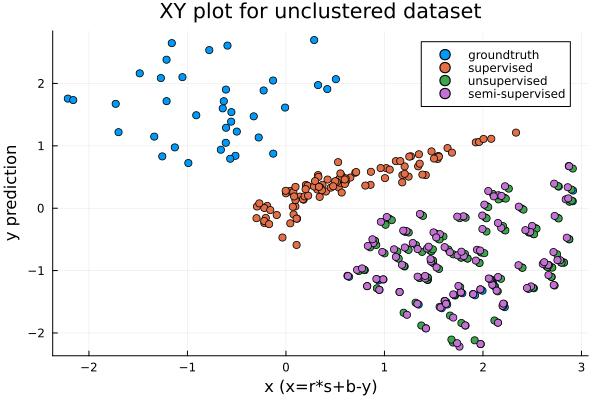

In [13]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(supervised_model, test_in, test_out, test_in_t, test_out_t; label="supervised") # reconstruct inside plot xy
plot_xy(unsupervised_model, test_in, test_out, test_in_t, test_out_t; label="unsupervised")
plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

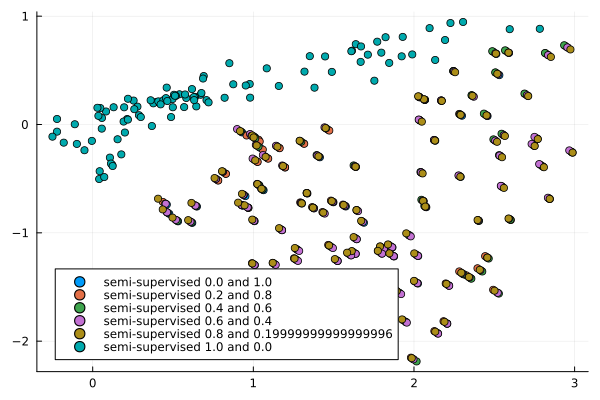

In [52]:
# tune h1 and h2
h12 = 0.0:0.2:1.0
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
h12_pl = plot()
for h in h12
    h1 = h
    h2 = 1-h
    semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs, h1=h1, h2=h2) 
    plot!(h12_pl, plot_xy(semisupervised_model, test_in, test_out, test_in_t, test_out_t; label="semi-supervised $(h1) and $(h2)"))
end
display(h12_pl)

# Learnings of 2. Experiment
- Supervised **cant converge on ambigous data**, averaging multiple modes
- Unsupervised **can converge on ambigous data**
- Semi-Supervised needs tuning of hyperparameters to converge, could they be optimized during training or be part of hyperparam search?
- loss values can be misleading or residual information is wrong

# 3. Experiment
For the third experiment, the **training time of Supervised and Unsupervised** are compared. Both methods are trained for 10, 100 and 1000 epochs and the training time is tracked and compared.

In [14]:
# preparation of 3. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)

epoch_range = [10,100,1000]
gen_unsupervised_data_time = 0.05 # seconds for 1000 datapoints
gen_supervised_data_time = 25 # seconds for 1000 datapoints

25

In [15]:
# 3. experiment unsupervised
full_unsupervised_test_loss_hist = []
full_res_unsupervised_test_loss_hist = []
full_unsupervised_train_time_hist = []
for n_epochs in epoch_range
  unsupervised_model, unsupervised_test_loss_hist, res_unsupervised_test_loss_hist,  unsupervised_time = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=n_epochs
    )
    push!(full_unsupervised_test_loss_hist, unsupervised_test_loss_hist[end])
    push!(full_res_unsupervised_test_loss_hist, res_unsupervised_test_loss_hist[end])
    push!(full_unsupervised_train_time_hist, unsupervised_time)
end

In [16]:
# 3. experiment supervised
full_supervised_test_loss_hist = []
full_res_supervised_test_loss_hist = []
full_supervised_train_time_hist = []
for n_epochs in epoch_range
  supervised_model, supervised_test_loss_hist, res_supervised_test_loss_hist, supervised_time = trainModelSupervised(
    deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu;epochs=n_epochs
    )
    push!(full_supervised_test_loss_hist, supervised_test_loss_hist[end])
    push!(full_res_supervised_test_loss_hist, res_supervised_test_loss_hist[end])
    push!(full_supervised_train_time_hist, supervised_time)
end

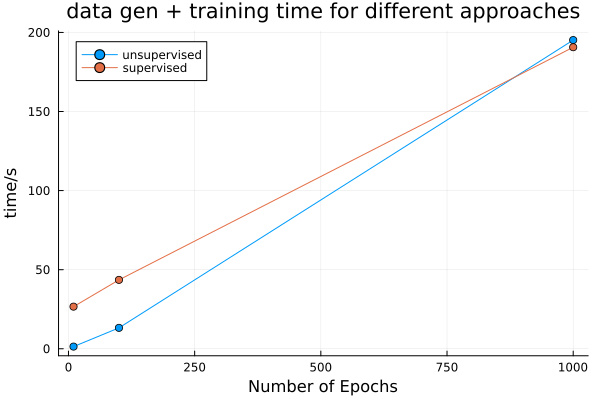

In [17]:
# results of 3. experiment
plot_loss_history(full_unsupervised_train_time_hist .+ gen_unsupervised_data_time, epoch_range; label="unsupervised", marker = :circle)
plot_loss_history!(full_supervised_train_time_hist .+ gen_supervised_data_time, epoch_range; label="supervised", marker = :circle)
title!("data gen + training time for different approaches")
xlabel!("Number of Epochs")
ylabel!("time/s")

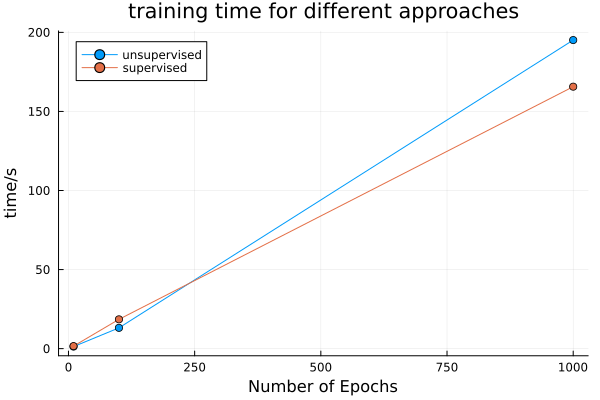

In [18]:
# results of 3. experiment
plot_loss_history(full_unsupervised_train_time_hist, epoch_range; label="unsupervised", marker = :circle)
plot_loss_history!(full_supervised_train_time_hist, epoch_range; label="supervised", marker = :circle)
title!("training time for different approaches")
xlabel!("Number of Epochs")
ylabel!("time/s")

# Learnings of 3. Experiment
- training time increases linearly with number of epochs
- unsupervised data generation is **~500 times faster** than supervised data generation
- actual training time of Supervised is lower than Unsupervised

# 4. Experiment
In the fourth experiment, Unsupervised training is compared for **different batchsizes**, namely 1 and 8.

In [19]:
# preparation of 4. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader_1 = Flux.DataLoader((train_in, train_out), batchsize=1, shuffle=true)
dataloader_8 = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true)

113-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=8)
  with first element:
  (2×8 Matrix{Float32}, 1×8 Matrix{Float32},)

In [20]:
# 4. experiment
unsupervised_model_1, unsupervised_test_loss_hist_1, res_unsupervised_test_loss_hist_1,  unsupervised_time_1 = trainModelUnsupervised(
    deepcopy(model), deepcopy(opt), dataloader_1, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs
    )

unsupervised_model_8, unsupervised_test_loss_hist_8, res_unsupervised_test_loss_hist_8,  unsupervised_time_8 = trainModelUnsupervised(
  deepcopy(model), deepcopy(opt), dataloader_8, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs
  )

(Chain(Dense(2 => 100, relu), Dense(100 => 100, relu), Dense(100 => 1)), Any[0.11465743f0, 0.08718218f0, 0.07988289f0, 0.078364186f0, 0.0816395f0, 0.07785761f0, 0.070109904f0, 0.0719608f0, 0.07877175f0, 0.07091359f0  …  0.077972725f0, 0.079651736f0, 0.07689712f0, 0.06835291f0, 0.0766095f0, 0.07277297f0, 0.078497045f0, 0.08103323f0, 0.06673705f0, 0.07771616f0], Any[0.872391185480479, 0.8803578647974339, 0.934541258629318, 0.9265705074224639, 0.8461096778154087, 0.8940663260757648, 0.9796201817269535, 0.9751381804598779, 0.8167752228340106, 1.0143491964088949  …  0.7941530754929645, 0.7102377128028151, 0.8077420605550542, 1.176500436529363, 0.8312438183058557, 0.9997423169059394, 0.7924440188277205, 0.7085416733751635, 1.242107961984176, 0.8437743995350898], 4.386058568954468)

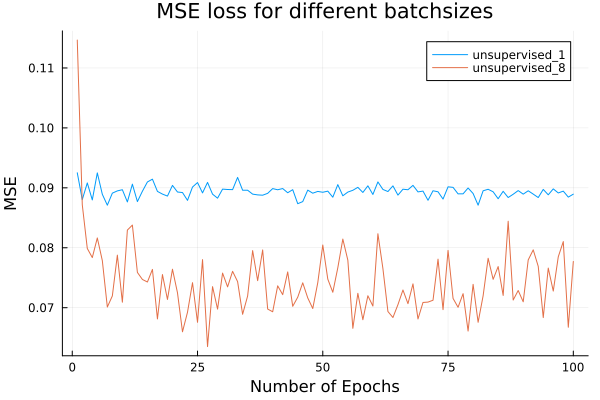

In [21]:
# results of 4. experiment
plot_loss_history(unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("MSE loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("MSE")

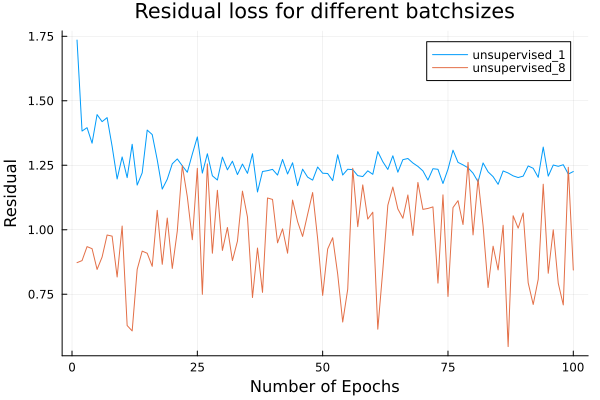

In [22]:
plot_loss_history(res_unsupervised_test_loss_hist_1; label="unsupervised_1")
plot_loss_history!(res_unsupervised_test_loss_hist_8; label="unsupervised_8")
title!("Residual loss for different batchsizes")
xlabel!("Number of Epochs")
ylabel!("Residual")

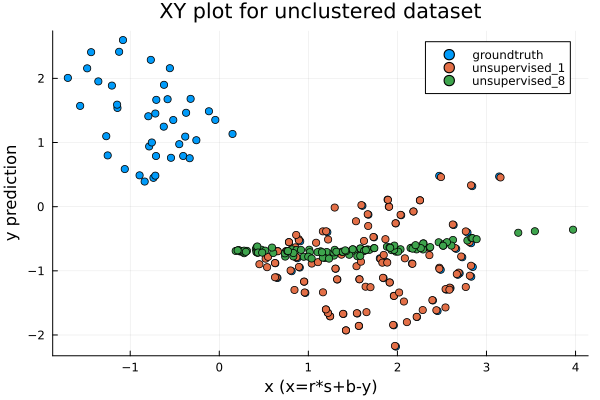

In [23]:
test_in_rec = StatsBase.reconstruct(test_in_t, test_in)
test_out_rec = StatsBase.reconstruct(test_out_t, test_out)
scatter(compute_x_from_y.(test_in_rec[1,:],test_in_rec[2,:],vec(test_out_rec)), vec(test_out_rec), label="groundtruth")
plot_xy(unsupervised_model_1, test_in, test_out, test_in_t, test_out_t; label="unsupervised_1")
plot_xy(unsupervised_model_8, test_in, test_out, test_in_t, test_out_t; label="unsupervised_8")
title!("XY plot for unclustered dataset")
xlabel!("x (x=r*s+b-y)")
ylabel!("y prediction")

# Learnings of 4. Experiment
- Unsupervised is probably useless cause **bigger batchsize leads to problems**.
- possible reasons: wrong backprop through reconstruct, if no reconstruct finite diff works out but prediction is way off
- maybe batchsize factor is wrong
- transpose(jac) * res is correct
- "linear" prediction

# IEEE14 Unsupervised
Now Unsupervised training is investigated in a **high dimensional scenario** with 15 inputs and 110 outputs. The loss on test data is tracked and the model predictions are plotted in 3D using PCA. In addition to Supervised, Unsupervised and Semi-Supervised, a Two-Step training procedure is tested which trains Unsupervised for the first half of epochs and Supervised with freezed layers for second half of epochs.

In [24]:
using MultivariateStats
include("trainTwoStep.jl")

trainTwoStep (generic function with 1 method)

In [25]:
# IEEE14 residual
fileName = "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/data/eq_1403.csv"
nInputs = 16
nOutputs = 110


comp, fmu, profilinginfo, vr, row_value_reference, eq_num, sys_num = prepare_fmu(
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/IEEE_14_Buses.interface.fmu",
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/profilingInfo.bson",
  "/home/fbrandt3/arbeit/NonLinearSystemNeuralNetworkFMU.jl/examples/IEEE14/data/sims/IEEE_14_Buses_1500/temp-profiling/IEEE_14_Buses.c")

# 1. some UNAMBIGOUS dataset and train all methods for performance
# prepare train and test data
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)

┌ Warning: No variable named 'time' found.
└ @ FMIImport /home/fbrandt3/.julia/packages/FMIImport/qrNjL/src/FMI2/convert.jl:153
┌ Warning: Value reference for variable 'time' not found, skipping.
└ @ FMIImport /home/fbrandt3/.julia/packages/FMIImport/qrNjL/src/FMI2/convert.jl:76


(Float32[0.16583967 0.45208833 … 0.52600884 0.13646975; 0.31079432 0.3209002 … 0.32201734 0.33145702; … ; 1.3272173 1.2487414 … 1.3302222 1.2904966; -0.34984684 -0.36385748 … -0.35197103 -0.35603634], Float32[-0.05027016 -0.055578325 … -0.054309648 -0.058325913; 0.03465814 0.033608958 … 0.034865472 0.03411097; … ; 0.9783953 0.94362754 … 0.977556 0.95697343; -0.4158242 -0.39532092 … -0.39890623 -0.39597386], Float32[0.005772156 0.00809723 … 1.0214685 1.0496447; 0.33315358 0.31489617 … 0.31330132 0.3075309; … ; 1.2093686 1.2271959 … 1.212018 1.286985; -0.33163917 -0.33846006 … -0.32797432 -0.35055986], Float32[-0.056371387 -0.05626667 … -0.02242961 -0.01028015; 0.034920588 0.033587478 … 0.024650907 0.025076812; … ; 0.9566843 0.9368798 … 0.6947278 0.71598536; -0.3661623 -0.38463128 … -0.26150677 -0.28023654])

In [26]:
CLUSTER = true
if CLUSTER
  # concat in and out data
  in_data = hcat(train_in, test_in)
  out_data = hcat(train_out, test_out)

  # cluster out data
  cluster_indices, num_clusters = cluster_data(out_data)
  # extract cluster
  cluster_index = 1 #rand(1:num_clusters)
  in_data = extract_cluster(in_data, cluster_indices, cluster_index)
  out_data = extract_cluster(out_data, cluster_indices, cluster_index)
else
  # take time out, probably earlier
  in_data = hcat(train_in, test_in)
  out_data = hcat(train_out, test_out)
end

┌ Warning: The clustering cost increased at iteration #14
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #17
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191


┌ Warning: The clustering cost increased at iteration #20
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #21
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #33
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191
┌ Warning: The clustering cost increased at iteration #40
└ @ Clustering /home/fbrandt3/.julia/packages/Clustering/JwhfU/src/kmeans.jl:191


110×957 Matrix{Float32}:
 -0.0502702  -0.0555783  -0.0523431  …  -0.0670484  -0.0530723  -0.0548347
  0.0346581   0.033609    0.0347577      0.0350688   0.034585    0.0346167
  0.164415    0.147618    0.164759       0.16225     0.166245    0.124266
 -0.122569   -0.107497   -0.12311       -0.122337   -0.125051   -0.0842718
  0.165503    0.17967     0.182739       0.195321    0.199986    0.195264
  0.0634446   0.0435825   0.063885   …   0.118831    0.0929631   0.0754739
  0.865178    0.842188    0.852108       0.895682    0.811599    0.876941
  0.0984931   0.0958667   0.0991671      0.0989398   0.0971734   0.098535
  0.155822    0.174891    0.173172       0.172817    0.183531    0.183134
 -0.0484749  -0.0463342  -0.0480557     -0.0450979  -0.0475273  -0.0454908
  ⋮                                  ⋱               ⋮          
  0.947669    0.916532    0.947378       0.936272    0.939891    0.937451
 -0.408766   -0.39072    -0.404814      -0.374815   -0.398491   -0.38112
 -0.427835   -0.40

In [27]:
# Warning: No variable named 'time' found.
in_data = in_data[2:end,:]  # take time variable out of in data

15×957 Matrix{Float32}:
  0.310794     0.3209       0.311318    …   0.30499      0.32638
  0.129056     0.132079     0.134439        0.134158     0.129851
  1.04064      1.00324      1.04488         1.00539      1.06018
  0.00642358   0.00718221   0.0100022       0.00489008   0.00525747
  1.26947      1.22788      1.23866         1.27508      1.29336
 -0.357612    -0.341096    -0.332629    …  -0.339133    -0.34583
  1.18328      1.15248      1.193           1.08138      1.11141
  0.00141069   0.00126368   0.00138623      0.00122131   0.0012611
  0.0972324    0.0981952    0.0999312       0.093222     0.100967
  1.20812      1.20868      1.22801         1.28205      1.20317
  0.226023     0.210618     0.21534     …   0.209381     0.226129
 -0.402654    -0.3977      -0.403069       -0.386326    -0.395838
  0.0038939    0.00192387   0.00236428      0.00286498   0.00116833
  1.32722      1.24874      1.31514         1.32693      1.21274
 -0.349847    -0.363857    -0.362593       -0.342109  

In [28]:
# split one cluster into train and test
train_in, train_out, test_in, test_out = split_train_test(in_data, out_data)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true)

96-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=8)
  with first element:
  (15×8 Matrix{Float32}, 110×8 Matrix{Float32},)

In [29]:
hidden_width = 100
model = Flux.Chain(
  Flux.Dense(nInputs-1, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, hidden_width, relu),
  Flux.Dense(hidden_width, nOutputs)
)

opt = Flux.Adam(1e-4)
epochs = 100

100

In [30]:
unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
semisupervised_model, semisupervised_test_loss_hist, semisupervised_time = trainModelSemisupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs, h1=0.8, h2=0.2)
twost_model, twost_test_loss_hist, twost_time = trainTwoStep(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)

(Chain(Dense(15 => 100, relu), Dense(100 => 100, relu), Dense(100 => 100, relu), Dense(100 => 100, relu), Dense(100 => 110)), Any[0.21886872f0, 0.15318397f0, 0.12240638f0, 0.10556801f0, 0.09844359f0, 0.09383796f0, 0.09277789f0, 0.091140546f0, 0.090370364f0, 0.088153966f0  …  0.032362316f0, 0.032334432f0, 0.032114778f0, 0.032093946f0, 0.0319572f0, 0.031875655f0, 0.031785924f0, 0.0316746f0, 0.031659532f0, 0.03149815f0], 0)

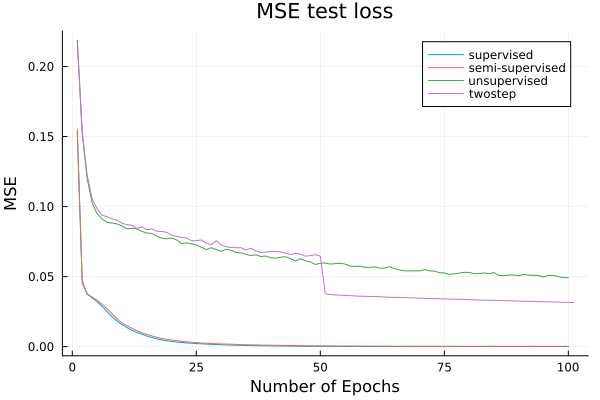

In [31]:
plot_loss_history(supervised_test_loss_hist; label="supervised")
plot_loss_history!(semisupervised_test_loss_hist; label="semi-supervised")
plot_loss_history!(unsupervised_test_loss_hist; label="unsupervised")
plot_loss_history!(twost_test_loss_hist; label="twostep")
title!("MSE test loss")
xlabel!("Number of Epochs")
ylabel!("MSE")

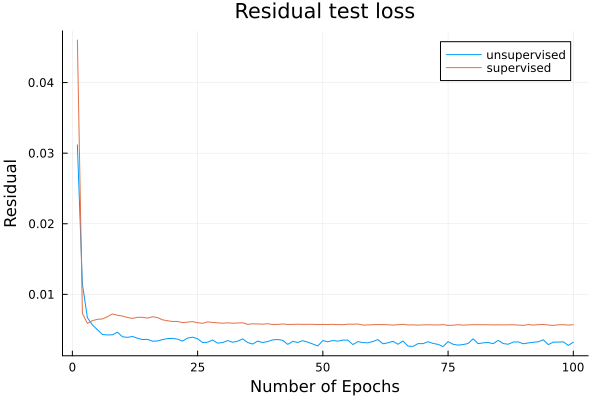

In [32]:
plot_loss_history(res_unsup; label="unsupervised")
plot_loss_history!(res_sup; label="supervised")
title!("Residual test loss")
xlabel!("Number of Epochs")
ylabel!("Residual")

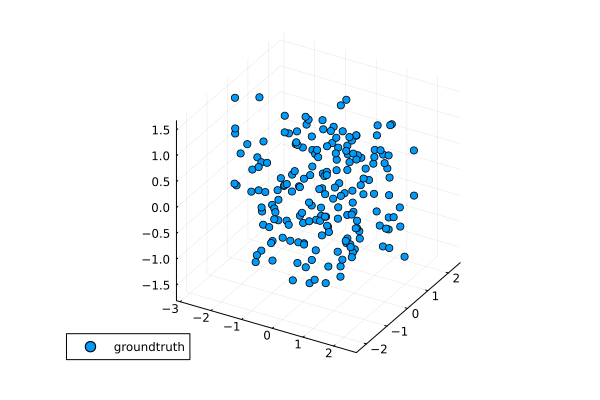

In [33]:
M1 = fit(PCA, test_out; maxoutdim=3)
O1 = predict(M1, test_out)
scatter(O1[1,:],O1[2,:],O1[3,:], label="groundtruth")

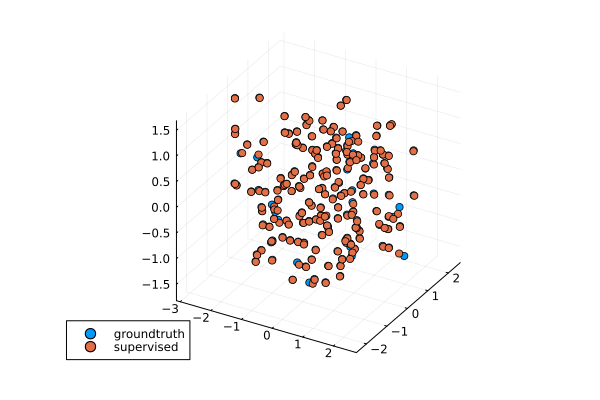

In [34]:
pred3 = supervised_model(test_in)
O3 = predict(M1, pred3)
scatter!(O3[1,:],O3[2,:],O3[3,:], label="supervised")

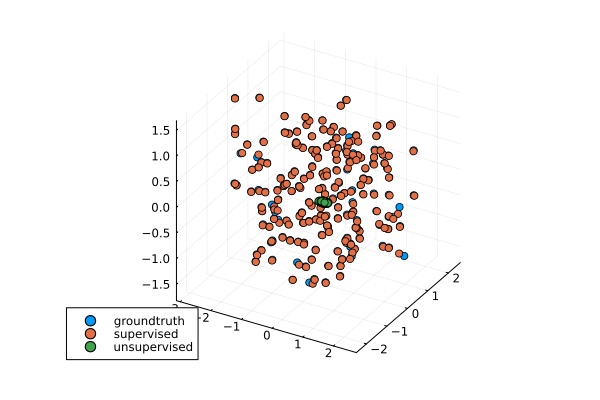

In [35]:
pred2 = unsupervised_model(test_in)
O2 = predict(M1, pred2)
scatter!(O2[1,:],O2[2,:],O2[3,:], label="unsupervised")

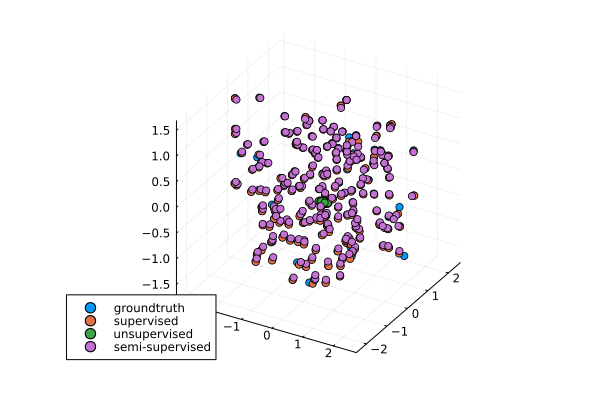

In [36]:
pred4 = semisupervised_model(test_in)
O4 = predict(M1, pred4)
scatter!(O4[1,:],O4[2,:],O4[3,:], label="semi-supervised")

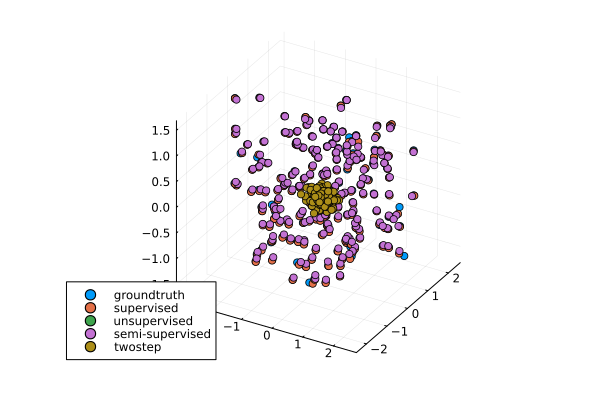

In [37]:
pred5 = twost_model(test_in)
O5 = predict(M1, pred5)
scatter!(O5[1,:],O5[2,:],O5[3,:], label="twostep")

# Learnings of IEEE14
- Unsupervised in higher dimension **does not seem to work well**, because it does not converge.
- The Prediction looks very "linear", just like in 3. experiment, maybe the residual information is wrong
- batchsize 1 doesnt help

# Results/Conclusion of whole Notebook
- fast data generation is good
- If everything is implemented correctly: **Unsupervised works in small dimensions but not in higher dimensions**.

In [38]:
# average multiple runs (BAD CODE I KNOW)
num_runs = 5
mean_loss_hist_sup = []
for i in 1:num_runs
    supervised_model, supervised_test_loss_hist, res_sup, supervised_time = trainModelSupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, deepcopy(row_value_reference), deepcopy(fmu); epochs=epochs)
    if i == 1
        mean_loss_hist_sup = supervised_test_loss_hist
    else
        #mean_loss_hist *= i-1 maybe this
        mean_loss_hist_sup += supervised_test_loss_hist
        mean_loss_hist_sup /= i
    end
end

mean_loss_hist_unsup = []
for i in 1:num_runs
    unsupervised_model, unsupervised_test_loss_hist, res_unsup, unsupervised_time = trainModelUnsupervised(deepcopy(model), deepcopy(opt), dataloader, test_in, test_out, train_in_t, test_in_t, train_out_t, test_out_t, eq_num, sys_num, row_value_reference, fmu; epochs=epochs)
    if i == 1
        mean_loss_hist_unsup = unsupervised_test_loss_hist
    else
        #mean_loss_hist *= i-1 maybe this
        mean_loss_hist_unsup += unsupervised_test_loss_hist
        mean_loss_hist_unsup /= i
    end
end

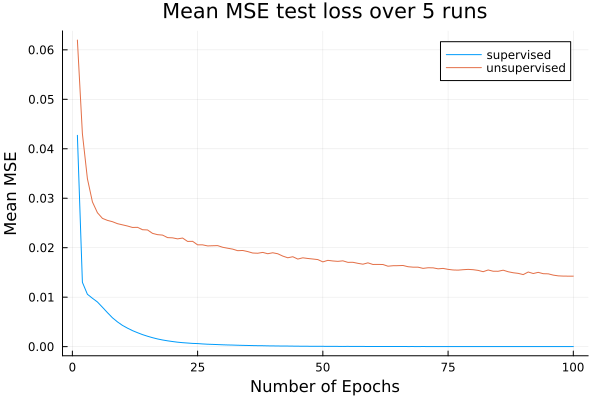

In [39]:
plot_loss_history(mean_loss_hist_sup; label="supervised")
plot_loss_history!(mean_loss_hist_unsup; label="unsupervised")
title!("Mean MSE test loss over $(num_runs) runs")
xlabel!("Number of Epochs")
ylabel!("Mean MSE")

In [66]:
function loss(y_hat, fmu, eq_num, sys_num, transform)
    bs = size(y_hat)[2] # batchsize
    residuals = Array{Vector{Float64}}(undef, bs)
    for j in 1:bs
        yj_hat = StatsBase.reconstruct(transform, y_hat[:,j])
        _, res = NonLinearSystemNeuralNetworkFMU.fmiEvaluateRes(fmu, eq_num, Float64.(yj_hat))
        residuals[j] = res
    end
    return 1/(2*bs)*sum(norm.(residuals).^2), if bs>1 residuals else residuals[1] end
end
  
function ChainRulesCore.rrule(::typeof(loss), x, fmu, eq_num, sys_num, transform)
    l, res = loss(x, fmu, eq_num, sys_num, transform)
    # evaluate the jacobian for each batch element
    bs = size(x)[2] # batchsize
    res_dim = if bs>1 length(res[1]) else length(res) end
    jac_dim = res_dim

    jacobians = Array{Matrix{Float64}}(undef, bs)
    for j in 1:bs
        xj = StatsBase.reconstruct(transform, x[:,j])
        _, jac = NonLinearSystemNeuralNetworkFMU.fmiEvaluateJacobian(comp, sys_num, vr, Float64.(xj))
        jacobians[j] = reshape(jac, (jac_dim,jac_dim))
    end

    function loss_pullback(l̄)
        l_tangent = l̄[1] # upstream gradient
        factor = l_tangent/bs # factor should probably be just: factor=l_tangent!!!!

        x̄ = Array{Float64}(undef, res_dim, bs)
        # compute x̄
        for j in 1:bs
            x̄[:,j] = transpose(jacobians[j]) * res[j]
        end
        x̄ = if transform.dims == 1 x̄ .* (1 ./ transform.scale)' elseif transform.dims == 2 x̄ .* (1 ./ transform.scale) end #!!!!
        x̄ *= factor

        # all other args have NoTangent
        f̄ = NoTangent()
        fmū = NoTangent()
        eq_num̄ = NoTangent()
        sys_num̄ = NoTangent()
        transform̄ = NoTangent()
        return (f̄, x̄, fmū, eq_num̄, sys_num̄, transform̄)
    end

    return l, loss_pullback
end

In [67]:
# preparation of 2. experiment
(train_in, train_out, test_in, test_out) = readData(fileName, nInputs)
train_in, train_out, test_in, test_out, train_in_t, train_out_t, test_in_t, test_out_t = scale_data_uniform(train_in, train_out, test_in, test_out)
dataloader = Flux.DataLoader((train_in, train_out), batchsize=8, shuffle=true)

169-element DataLoader(::Tuple{Matrix{Float32}, Matrix{Float32}}, shuffle=true, batchsize=8)
  with first element:
  (16×8 Matrix{Float32}, 110×8 Matrix{Float32},)

In [68]:
x = first(dataloader)[2]
loss(x, fmu, eq_num, sys_num, train_out_t)

(0.006041123017045136, [[-1.7635095828083536e-8, 0.002533025388239518, -0.005726331914261418, 1.4766678210070827e-9, -4.530724137877251e-8, 5.161276362894429e-10, -2.2883276384888518e-9, -7.014870642696458e-9, 3.7247836592868566e-8, 7.014870642696458e-9  …  -2.0879879596147344e-9, 1.4817565679656197e-8, 4.9584954975312456e-8, 0.0006989646690529691, 0.000695932193446297, -1.083661493872512e-8, 3.1497690566872905e-10, 2.366737250625306e-9, -0.018120483949241595, 0.005842316708281947], [-3.0800116623819207e-9, 0.004281522267913007, -0.01018232834628946, -1.2760981889237133e-9, 5.7002119718818633e-8, 2.1571789649704742e-9, 7.365277276960569e-10, -5.36575913562265e-9, 5.1331669088938714e-8, 5.36575913562265e-9  …  4.1121616875527955e-10, -6.196796895063805e-9, 2.2235512736612506e-9, 0.0025446522335095915, 0.002635784440053246, -4.6645029616598777e-8, -7.321148742800432e-9, -2.6980639250551164e-9, 0.010042612138676188, -0.05900737015075874], [-3.1971210401327e-9, 0.0034637678626192603, -0.00

In [69]:
l, pullb = ChainRulesCore.rrule(loss, x, fmu, eq_num, sys_num, train_out_t)

0.0


0.2
0.4
0.6
0.8
1.0
